## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import matplotlib
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import ll_to_xy
import matplotlib.patheffects as pe
from netCDF4 import Dataset

import warnings
warnings.filterwarnings('ignore')

## 1. Simulation Data

In [3]:
variable = 'PRCP'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

### 1.1 ERA5

#### 1.1.1 Data Options

In [4]:
run_data = 'era5'
start_utc = 8
end_utc = 13

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [5]:
data_path

['data/era5_LIN_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_LIN_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_urban_PRCP_wrfout_d03_2017-07-18.nc']

#### 1.1.2 Open Data

In [6]:
# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens').isel(time=slice(start_utc, end_utc))[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt_era5 = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

In [7]:
dt_era5

<xarray.DataArray 'PRCP' (ens: 6, time: 5, south_north: 200, west_east: 200)>
dask.array<getitem, shape=(6, 5, 200, 200), dtype=float32, chunksize=(1, 5, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    xtime        (time) datetime64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18T08:00:00 ... 2017-07-18T12:...
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * ens          (ens) object 'LIN_nourban_PRCP' ... 'WSM6_urban_PRCP'
    spatial_ref  int64 0
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    description:   Total precipitation rate
    units:         mm h-1
    stagger:       
    pyproj_srs:    +proj=lcc +lat_0=41.0720100402832 +lon_0=28.9729995727539 ...
    coordinates:   XLONG XLAT XTIME
    grid_mapping:  spatial_ref

#### 1.1.3 Define Members

In [8]:
# ensemble member list
ensemble_members = list(dt.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

#### 1.1.4 Ensemble Mean For Urban and Nourban

In [9]:
dt_era5_urban_ens = dt_era5.sel(ens=urban_members).mean(dim='ens')
dt_era5_nourban_ens = dt_era5.sel(ens=nourban_members).mean(dim='ens')

In [10]:
dt_era5_ens_diff = dt_era5_urban_ens - dt_era5_nourban_ens

### 1.2 GFS

#### 1.2.1 Data Options

In [11]:
run_data = 'era5' # gfs in normal
start_utc = 8
end_utc = 13

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [12]:
data_path

['data/era5_LIN_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_LIN_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_urban_PRCP_wrfout_d03_2017-07-18.nc']

#### 1.2.2 Open Data

In [13]:
# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens').isel(time=slice(start_utc, end_utc))[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt_gfs = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

In [14]:
dt_gfs

<xarray.DataArray 'PRCP' (ens: 6, time: 5, south_north: 200, west_east: 200)>
dask.array<getitem, shape=(6, 5, 200, 200), dtype=float32, chunksize=(1, 5, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    xtime        (time) datetime64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18T08:00:00 ... 2017-07-18T12:...
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * ens          (ens) object 'LIN_nourban_PRCP' ... 'WSM6_urban_PRCP'
    spatial_ref  int64 0
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    description:   Total precipitation rate
    units:         mm h-1
    stagger:       
    pyproj_srs:    +proj=lcc +lat_0=41.0720100402832 +lon_0=28.9729995727539 ...
    coordinates:   XLONG XLAT XTIME
    grid_mapping:  spatial_ref

#### 1.2.3 Ensemble Mean For Urban and Nourban

In [15]:
dt_gfs_urban_ens = dt_gfs.sel(ens=urban_members).mean(dim='ens')
dt_gfs_nourban_ens = dt_gfs.sel(ens=nourban_members).mean(dim='ens')

In [16]:
dt_gfs_ens_diff = dt_gfs_urban_ens - dt_gfs_nourban_ens

### 1.3 Sample Graphics

#### 1.3.1 ERA5 urban-nourban

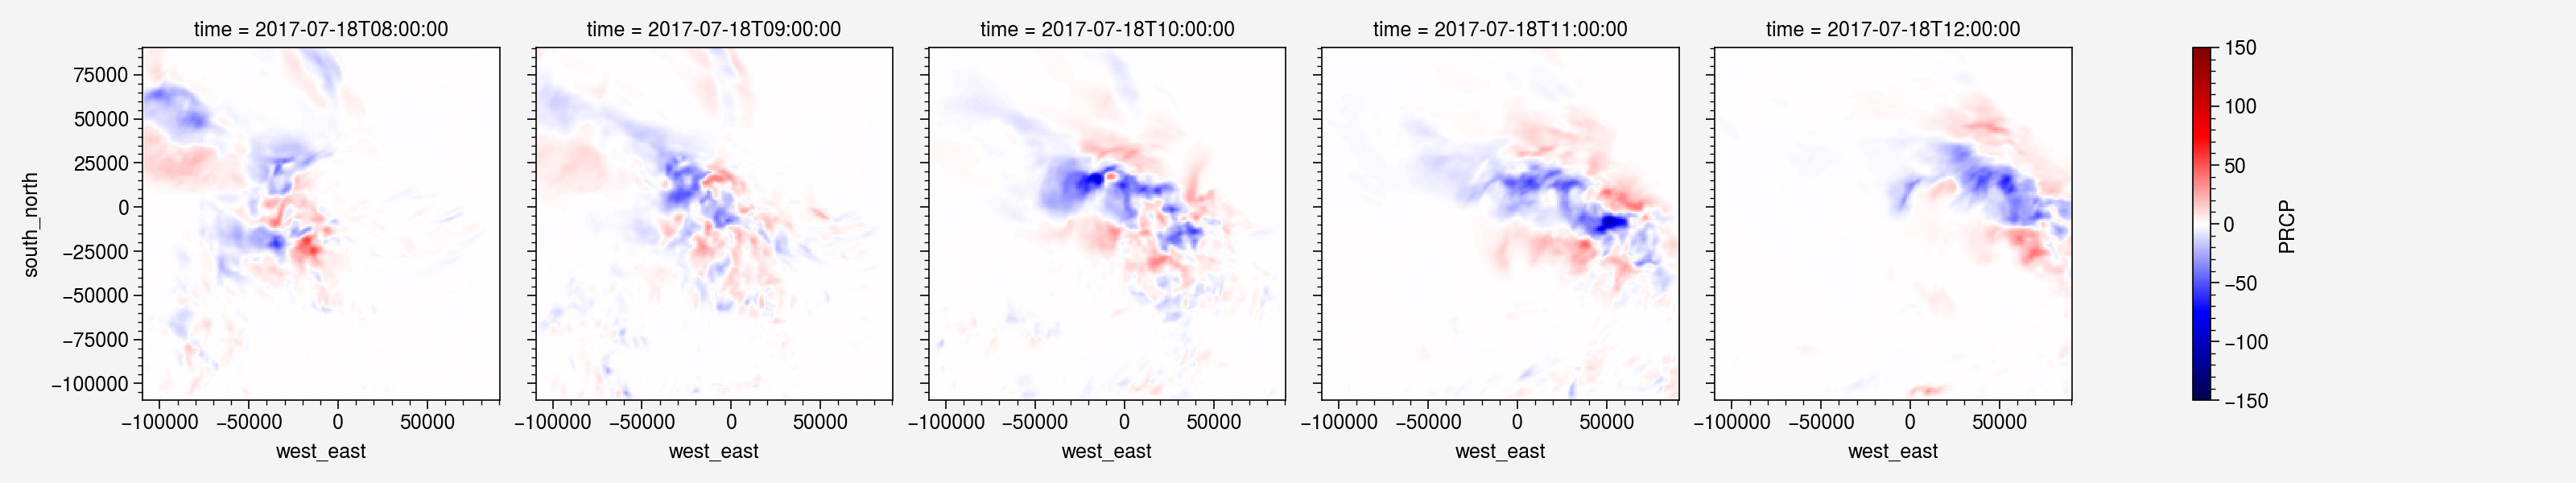

In [17]:
# era5
dt_era5_ens_diff.plot(col='time', 
      col_wrap=5,
      vmin=-150,
      vmax=150,
      cmap='seismic')

#### 1.3.2 GFS

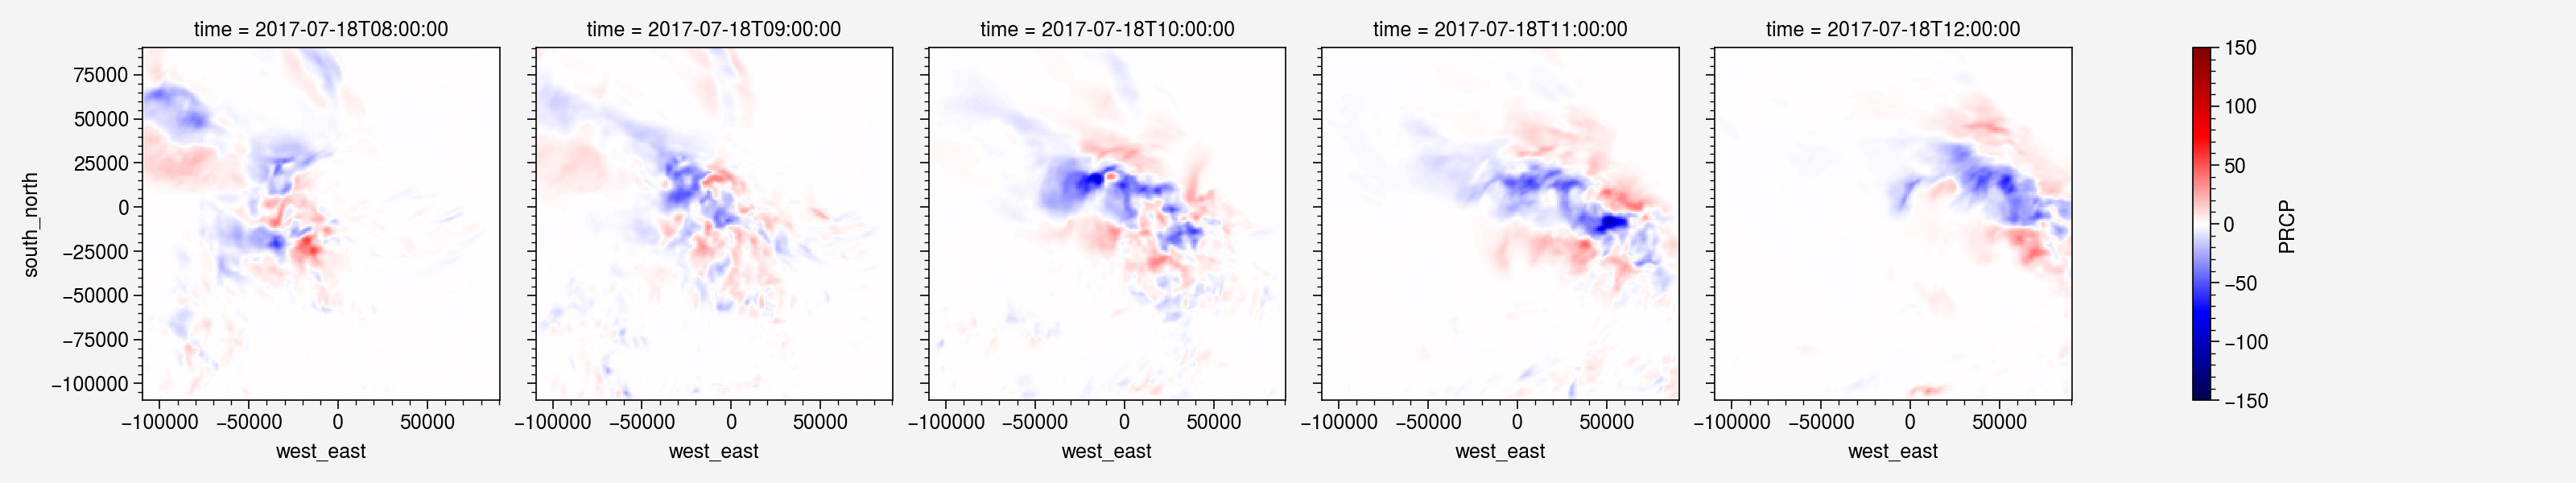

In [18]:
# gfs
dt_gfs_ens_diff.plot(col='time', 
      col_wrap=5,
      vmin=-150,
      vmax=150,
      cmap='seismic')

## 2. Visualization

### 2.1 Open Land Use Datasets

In [19]:
luse_var = 'LU_INDEX'
urban_luse_border = xr.open_dataset(fr'{general_path}/wrfout_d03_LU_INDEX_urban.nc')[luse_var]
urban_luse_border = urban_luse_border.where(urban_luse_border==1, 0).isel(west_east = slice(35, 162),
                                                                               south_north = slice(57, 157))

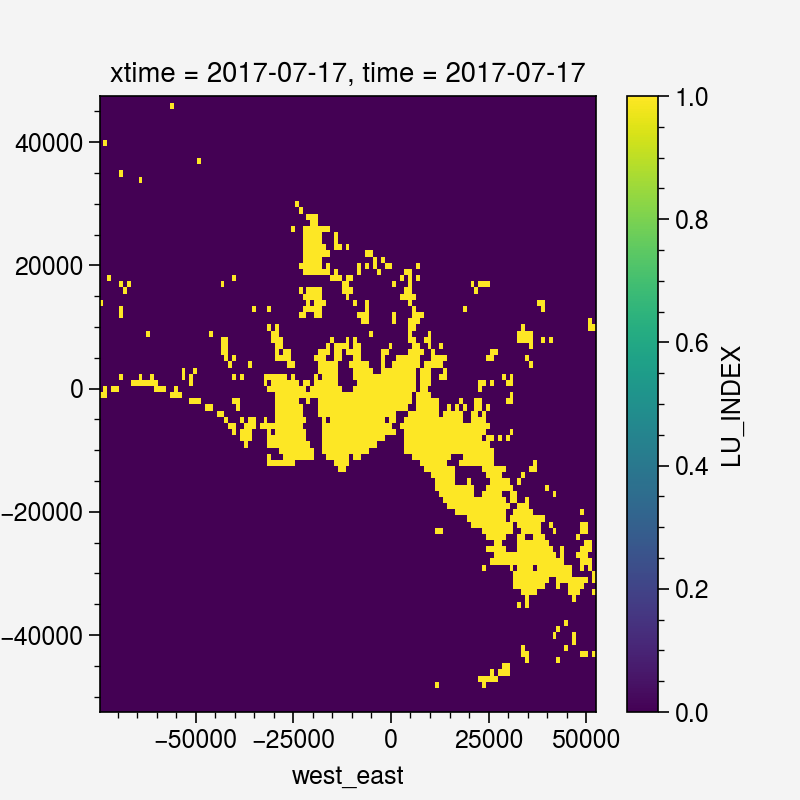

In [20]:
urban_luse_border.plot()

### 4.2 Parameters

In [33]:
# Parameters to change (plot) -------------------
# projection
proj = dt.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1,2],
             [3,4],
             [5,6],
             [7,8],
             [9,10]
            ]
graphic_no = 10

# cmap and norm
cmap = matplotlib.cm.seismic
clevs_total = np.arange(-140, 140.1, 20)
ticks = np.arange(-140, 140.1, 140)
cut = -0.1

# color norm
norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)

### 4.3 Plot

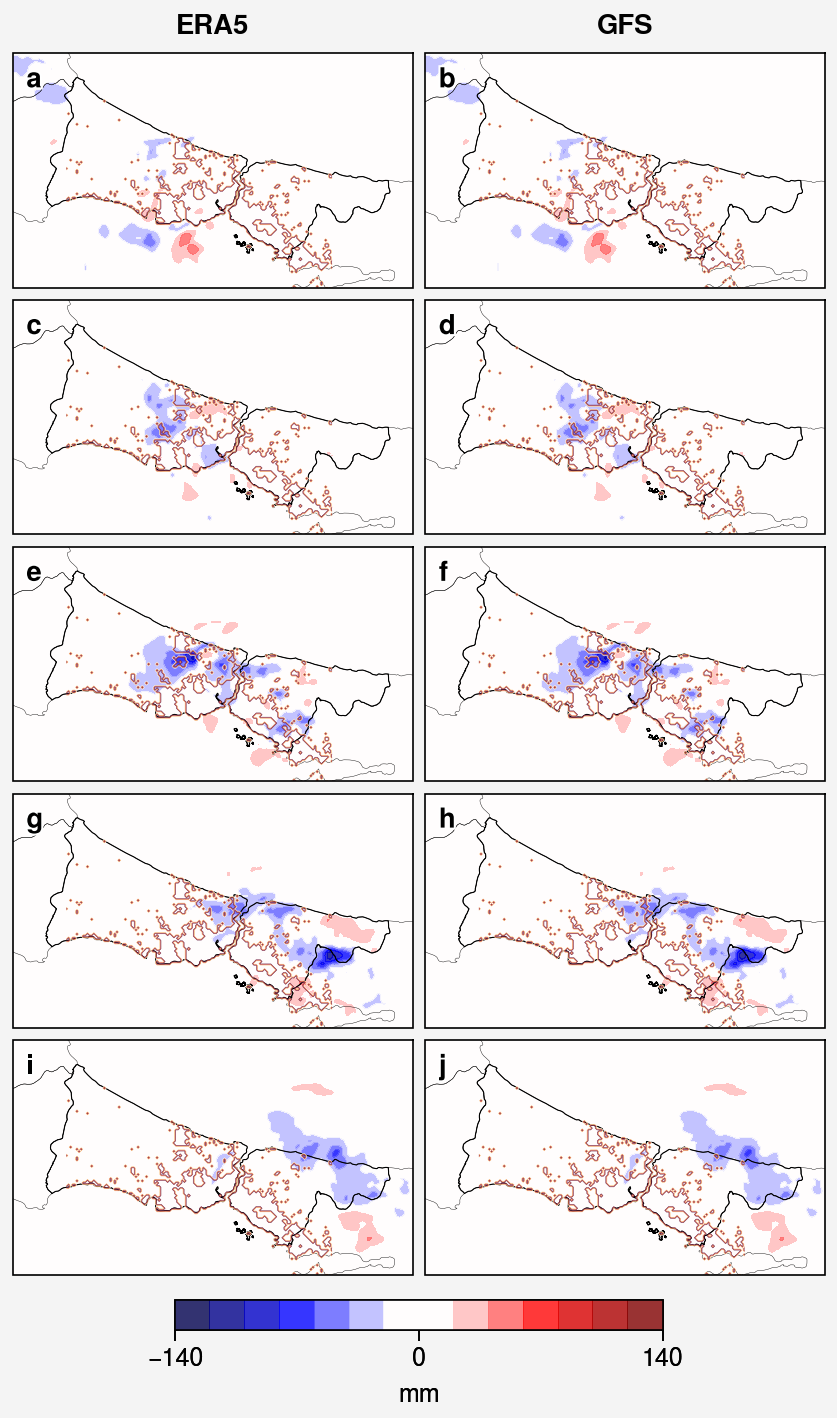

In [36]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=4,
                            axwidth=2,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.5,
                            wspace=0.5,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           abc=True,
           )

# istanbul limits
axs.format(lonlim=(27.69171143+0.10, 30.04271274),
           latlim=(40.08444595+0.60, 41.88309609-0.20),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(collabels=['ERA5', 'GFS'],
           #collabels=['08UTC', '09UTC', '10UTC', '11UTC']
           )
#proplot.rc['leftlabel.rotation'] = 'vertical'
proplot.rc.update({'leftlabel.rotation':'vertical'})

# add shapefiles
turkey_district_shape = r'data/shapefiles/istanbul_province_borders.shp'
shape_district_turkey = ShapelyFeature(Reader(turkey_district_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.4, zorder = 0.3)

turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
shape_province_turkey = ShapelyFeature(Reader(turkey_province_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.15, zorder = 0.4)


for i in range(graphic_no):
    axs[i].add_feature(shape_district_turkey)
    axs[i].add_feature(shape_province_turkey)  
    
    
dt_border = urban_luse_border
titles_era5 = ['08 UTC', '08 UTC'
               '09 UTC', '09 UTC'
               '10 UTC', '10 UTC'
               '11 UTC', '11 UTC'
               '12 UTC', '12 UTC'
               ]

titles_gfs = ['08 UTC', '08 UTC'
               '09 UTC', '09 UTC'
               '10 UTC', '10 UTC'
               '11 UTC', '11 UTC'
               '12 UTC', '12 UTC'
               ]

i_s = [0,0,1,1,2,2,3,3,4,4]
for i, t in zip(i_s, range(graphic_no)):
            
    if t in [0,2,4,6,8]:
        dt_luse = dt_era5_ens_diff
        #i = t
    else:
        dt_luse = dt_gfs_ens_diff
        #i = t-5
        
    mesh = axs[t].contourf(dt_luse[i]['lon'], 
                            dt_luse[i]['lat'],
                            dt_luse[i], 
                            cmap = cmap,
                            cmap_kw={'cut': cut},
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)
    
    contour = axs[t].contour(dt_border['lon'], 
                            dt_border['lat'],
                            dt_border,
                            lw = 0.1,
                            )
    #axs[t].format(lowerlefttitle=titles_era5[t],
    #              fontweight='bold')

# colorbar
cbar = fig.colorbar(mesh,
                    label='mm',
                    ticks = ticks,
                    loc = 'b',
                    shrink = 0.6,
                    width = 0.15
                    #col=2
                   )

#save figure
plt.savefig(r'pictures/combined_precipitation_difference_hourly.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)